## RLlib PPO policy evaluation

In [1]:
import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo
from ray import serve

In [2]:
ray.init()

2022-06-19 14:20:25,472	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '192.168.88.128', 'raylet_ip_address': '192.168.88.128', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-19_14-20-23_706276_24012/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-19_14-20-23_706276_24012/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-06-19_14-20-23_706276_24012', 'metrics_export_port': 47801, 'gcs_address': '192.168.88.128:65164', 'address': '192.168.88.128:65164', 'node_id': '5d0762ca671494e6b283e3ad86679ac6ba3f58eaa5b58cecefd8b8d7'})

In [3]:
from config import Config
from data_prep import DataPrep
from env import CMAPSSEnv
from VAE_dense import *
from tf_serve_models import TFEncoderDecoderModel

# Load options
serve.start()
TFEncoderDecoderModel.deploy(['./saved_models/encoder','./saved_models/decoder'])

const = Config()
neurons = const.VAE_neurons

# Data prep
# Load the 3rd batch of data which are for policy evaluation
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

df = data.ReadData()
print(df)

# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "models": [None, None],
    "env_type": env_types[0],
}

env_name = "CMAPSS_env"
register_env(env_name, lambda config: CMAPSSEnv(**env_config))

(ServeController pid=24827) 2022-06-19 14:20:28,383	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=24827) 2022-06-19 14:20:28,486	INFO http_state.py:106 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:kojkVM:SERVE_PROXY_ACTOR-node:192.168.88.128-0' on node 'node:192.168.88.128-0' listening on '127.0.0.1:8000'
2022-06-19 14:20:28,937	INFO api.py:794 -- Started Serve instance in namespace '527df8c6-70dd-4e04-b02f-a9f02704a1ef'.
2022-06-19 14:20:28,942	INFO api.py:615 -- Updating deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(HTTPProxyActor pid=24865) INFO:     Started server process [24865]
(ServeController pid=24827) 2022-06-19 14:20:29,013	INFO deployment_state.py:1216 -- Adding 1 replicas to deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel


(TFEncoderDecoderModel pid=24906) Model: "encoder"
(TFEncoderDecoderModel pid=24906) __________________________________________________________________________________________________
(TFEncoderDecoderModel pid=24906)  Layer (type)                   Output Shape         Param #     Connected to                     
(TFEncoderDecoderModel pid=24906) ==================================================================================================
(TFEncoderDecoderModel pid=24906)  input_1 (InputLayer)           [(None, 25)]         0           []                               
(TFEncoderDecoderModel pid=24906)                                                                                                   
(TFEncoderDecoderModel pid=24906)  dense_layer_0 (Dense)          (None, 256)          6656        ['input_1[0][0]']                
(TFEncoderDecoderModel pid=24906)                                                                                                   
(TFEncoderDecoderM

2022-06-19 14:20:31,950	INFO api.py:630 -- Deployment 'TFEncoderDecoderModel' is ready at `http://127.0.0.1:8000/saved_models`. component=serve deployment=TFEncoderDecoderModel


      Unit  NormTime  OpSetting1  OpSetting2  OpSetting3   Sensor1   Sensor2  \
0      241  0.994536    0.595099    0.736342    0.000000  0.238089  0.010311   
1      241  0.989071    0.797537    0.866983    0.500000  0.119044  0.069186   
2      241  0.983607    0.531704    0.578385    0.666667  0.412696  0.374609   
3      241  0.978142    0.607066    0.683462    0.750000  0.324589  0.326804   
4      241  0.972678    0.580878    0.713040    0.800000  0.385069  0.393832   
...    ...       ...         ...         ...         ...       ...       ...   
4359   260  0.012658    0.570459    0.676921    0.856651  0.377519  0.407050   
4360   260  0.009494    0.570383    0.676835    0.856684  0.377569  0.407105   
4361   260  0.006329    0.570389    0.676848    0.856488  0.377537  0.407016   
4362   260  0.003165    0.570394    0.676862    0.856292  0.377505  0.406927   
4363   260  0.000000    0.570455    0.676936    0.856324  0.377433  0.406879   

       Sensor3   Sensor4   Sensor5  ...

In [4]:
# Locate checkpoints
checkpoint_path = "/home/erotokritos/ray_results/CMAPSS_env/PPO_CMAPSS_env_ce374_00000_0_2022-06-19_10-19-18/checkpoint_000081/checkpoint-81"

In [5]:
# Restore agent from last checkpoint

agent = ppo.PPOTrainer(
    config={
            "env": env_name,
            "num_workers": 1,
            "num_gpus": 0,
            "log_level": "INFO",
            "explore": False,
        })

agent.restore(checkpoint_path)

2022-06-19 14:20:39,248	INFO trainer.py:2295 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-06-19 14:20:39,255	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=24966) 2022-06-19 14:20:41,842	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=24966) 2022-06-19 14:20:41,842	WARNI

In [6]:
env = CMAPSSEnv(**env_config)

In [7]:
eval_data = np.empty([sum(engine_lives), const.num_settings + const.num_sensors+1])
eval_data.shape

(4364, 25)

In [8]:
obs, done = env.reset(), False
cntr = 0

while not done:
    action = agent.compute_single_action(obs)
    obs, _, done, _ = env.step(action)
    eval_data[cntr] = obs
    cntr += 1

2022-06-19 14:21:05,759	INFO tf_run_builder.py:98 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.


In [9]:
import pandas as pd

eval_df = pd.DataFrame(eval_data, columns=df.columns[1:])
#eval_df.head(10)

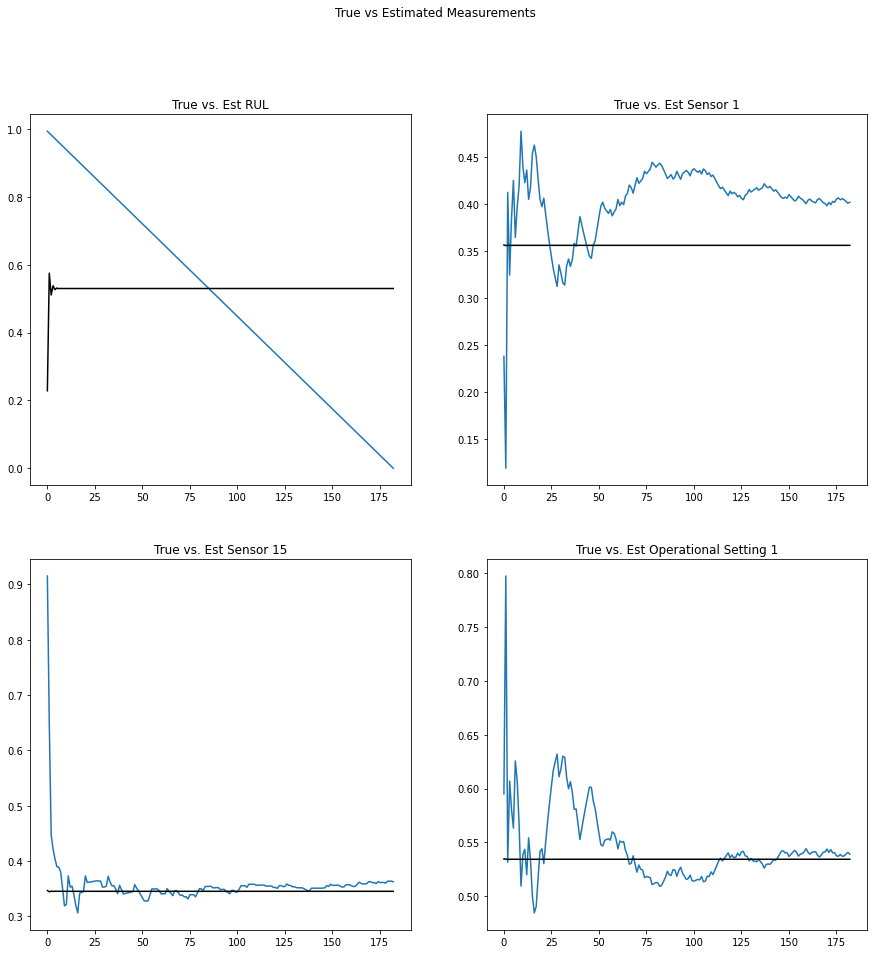

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('True vs Estimated Measurements')
plt.rcParams["figure.figsize"] = (10,10)

axs[0, 0].plot(df['NormTime'].iloc[0:engine_lives[0]])
axs[0, 0].plot(eval_df['NormTime'].iloc[0:engine_lives[0]], color='black')
axs[0, 0].title.set_text('True vs. Est RUL')

axs[0, 1].plot(df['Sensor1'].iloc[0:engine_lives[0]])
axs[0, 1].plot(eval_df['Sensor1'].iloc[0:engine_lives[0]], color='black')
axs[0, 1].title.set_text('True vs. Est Sensor 1')

axs[1, 0].plot(df['Sensor15'].iloc[0:engine_lives[0]])
axs[1, 0].plot(eval_df['Sensor15'].iloc[0:engine_lives[0]], color='black')
axs[1, 0].title.set_text('True vs. Est Sensor 15')

axs[1, 1].plot(df['OpSetting1'].iloc[0:engine_lives[0]])
axs[1, 1].plot(eval_df['OpSetting1'].iloc[0:engine_lives[0]], color='black')
axs[1, 1].title.set_text('True vs. Est Operational Setting 1')

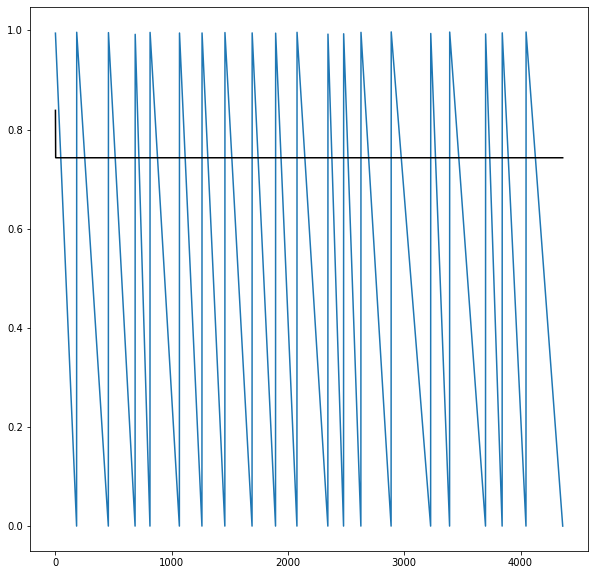

In [15]:
plt.plot(df['NormTime'])
plt.plot(eval_df['NormTime'], color='black')

In [24]:
ray.shutdown()